# Statistics on SVM

We will arange data and train SVC on the data.
Then we will try to train again only using quarters from the same cluster (using the quarter classifier).

Our randomly chosen 5 stocks are: 
'SHW', 'MNK', 'BIO', 'KYTH', 'KRO'

# Basic SVM

In [1]:
from Utilities.orginizers import LearningData, TrainingData
from sklearn.model_selection import KFold, cross_val_score
from Utilities.confusion_matrix import ConfusionMatrix
from itertools import product
from sklearn.svm import SVC

from multiprocessing import Pool
import matplotlib.pyplot as plt
import Utilities
import numpy as np
import warnings
import logging
import pandas
import numpy

%matplotlib inline

ld = LearningData()

In [2]:
stock_names = ('SHW', 'MNK', 'BIO', 'KYTH', 'KRO')
logging.getLogger().setLevel(logging.ERROR)
stocks = [TrainingData(sn).add_history(10).get() for sn in stock_names]

In [3]:
import os
print("Samples per stock:")
print(os.linesep.join(['{} {}'.format(sn, len(data)) for sn, (data, classes) in zip(stock_names, stocks)]))
print("percent of positive classification per stock")
print(os.linesep.join(['{} {}'.format(sn, float(classes.sum())/len(classes)) for sn, (data, classes) in zip(stock_names, stocks)]))
print(stocks[0][0].describe())

Samples per stock:
SHW 7855
MNK 819
BIO 2343
KYTH 718
KRO 3220
percent of positive classification per stock
SHW 0.20038192234245703
MNK 0.1978021978021978
BIO 0.15151515151515152
KYTH 0.201949860724234
KRO 0.20031055900621117
             change        close   ex-divident         high           low  \
count  7.855000e+03  7855.000000  7.855000e+03  7855.000000  7.855000e+03   
mean   2.170977e-17     0.000000  1.447318e-17     0.000000 -1.447318e-16   
std    1.000064e+00     1.000064  1.000064e+00     1.000064  1.000064e+00   
min   -9.826291e-01    -0.711964 -8.285474e-02    -0.708525 -7.122042e-01   
25%   -6.546142e-01    -0.545740 -8.285474e-02    -0.546135 -5.453623e-01   
50%   -2.623907e-01    -0.438244 -8.285474e-02    -0.440260 -4.366827e-01   
75%    3.430775e-01    -0.053682 -8.285474e-02    -0.052620 -5.562959e-02   
max    1.404981e+01     3.669051  2.486545e+01     3.637710  3.656416e+00   

               open   split_ratio        volume  change1_days_before  \
count  7

In [3]:
def run_model(model, inp=stocks):
    matrixes = {sn: [] for sn in stock_names}
    for sn, data in zip(stock_names, inp):
        matrixes[sn] = ConfusionMatrix(data, model)
    return matrixes

def alt_sum(accs):
    tmp = 0 
    for k in accs.keys():
        tmp+=accs[k].accuracy
    return tmp
    
def alt_median(accs):
    lst = []
    for k in accs.keys():
        lst.append(accs[k].accuracy)
    lst = sorted(lst)
    return numpy.median(lst)
    
    
def get_best_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if alt_sum(accs) > best_model[0]:
            best_model = (alt_sum(accs), model)
    return best_model

def median(lst):
    quotient, remainder = divmod(len(lst), 2)
    if remainder:
        return sorted(lst)[quotient]
    return sum(sorted(lst)[quotient - 1:quotient + 1]) / 2.

def get_best_median_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if alt_median(accs) > best_model[0]:
            best_model = (alt_median(accs), model)
    return best_model

In [4]:
from pandas import DataFrame

def get_results(models, accuracies=None):
    if accuracies is None:
        accuracies = list(map(run_model, models))
    # data should be list of lists and each row should be:
    # criterion, max_depth, min_samples, stock, accuracy
    data = []
    for tmodel, taccs in zip(models, accuracies):
        for tsn, cm in taccs.items():
            data.append((tmodel.C, tmodel.kernel, tmodel.max_iter, tmodel.gamma, tsn, cm.accuracy, cm.true_acc(), cm.false_acc(), cm.TruePos))
    results = DataFrame(data, columns=('C', 'kernel', 'max_iter', 'gamma', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))
    return results

In [5]:
from pandas import DataFrame

def get_results_class_weigth(models, accuracies=None):
    if accuracies is None:
        accuracies = list(map(run_model, models))
    # data should be list of lists and each row should be:
    # criterion, max_depth, min_samples, stock, accuracy
    data = []
    for tmodel, taccs in zip(models, accuracies):
        for tsn, cm in taccs.items():
            data.append((tmodel.class_weight[True], tsn, cm.accuracy, cm.true_acc(), cm.false_acc(), cm.TruePos))
    results = DataFrame(data, columns=('class_weight', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))
    return results

/home/eytan/work/Stockifier/Utilities/confusion_matrix.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return self.TruePos / (self.TruePos + self.FalsePos)


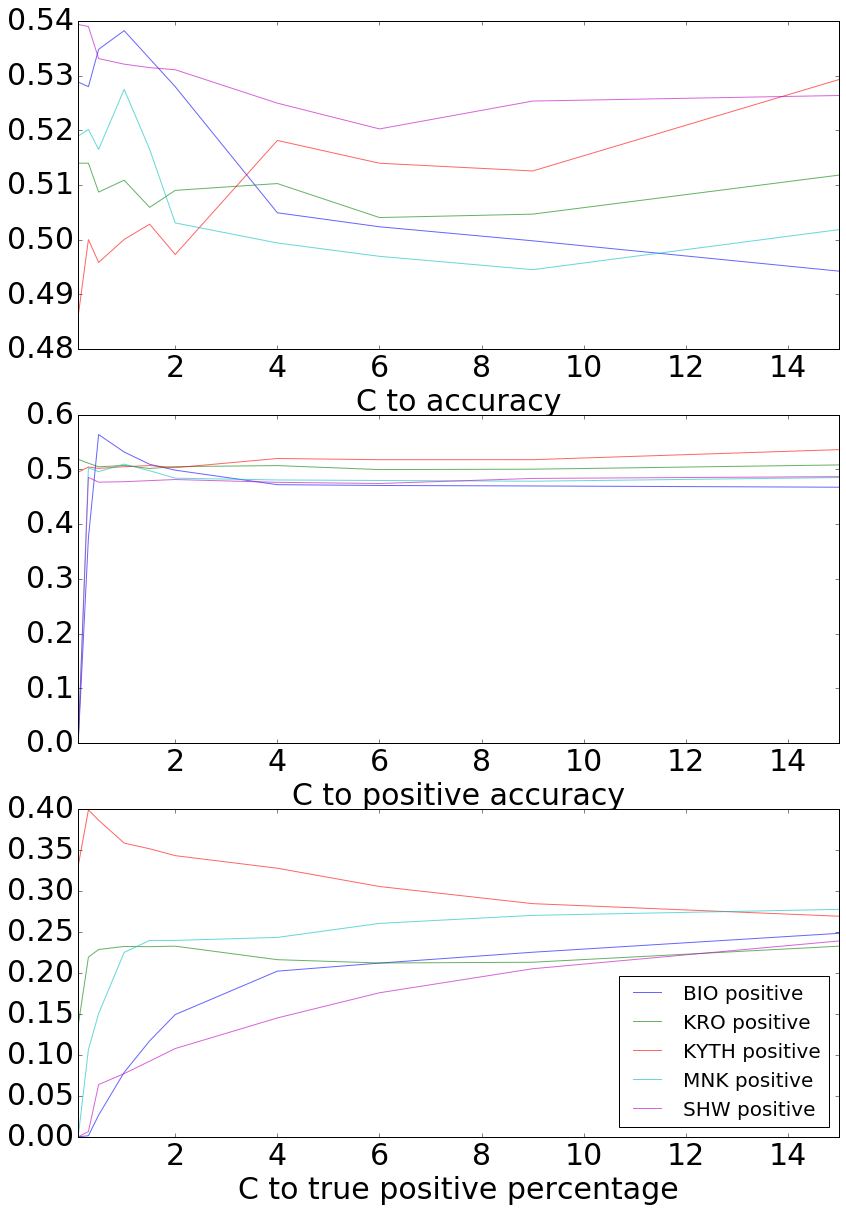

In [6]:
import numpy as np
from sklearn.svm import SVC

%matplotlib inline

C = [0.1, 0.3, 0.5, 1.0, 1.5, 2,4,6.0,9.0,15.0]
#C = [0.5]
models = [SVC(C=d) for d in C]
results = get_results(models)

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('C').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('C to accuracy')

ax2 = plt.subplot2grid((3,2), (1,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 0).groupby('C').agg('mean')['positive acc'].plot(kind='line', label=name+' positive', alpha=alpha)
ax2.set_xlabel('C to positive accuracy')

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.groupby('C').agg('mean')['true positive'].plot(kind='line', label=name+' positive', alpha=alpha)
ax3.set_xlabel('C to true positive percentage')

plt.legend(loc='best', prop={'size':20})

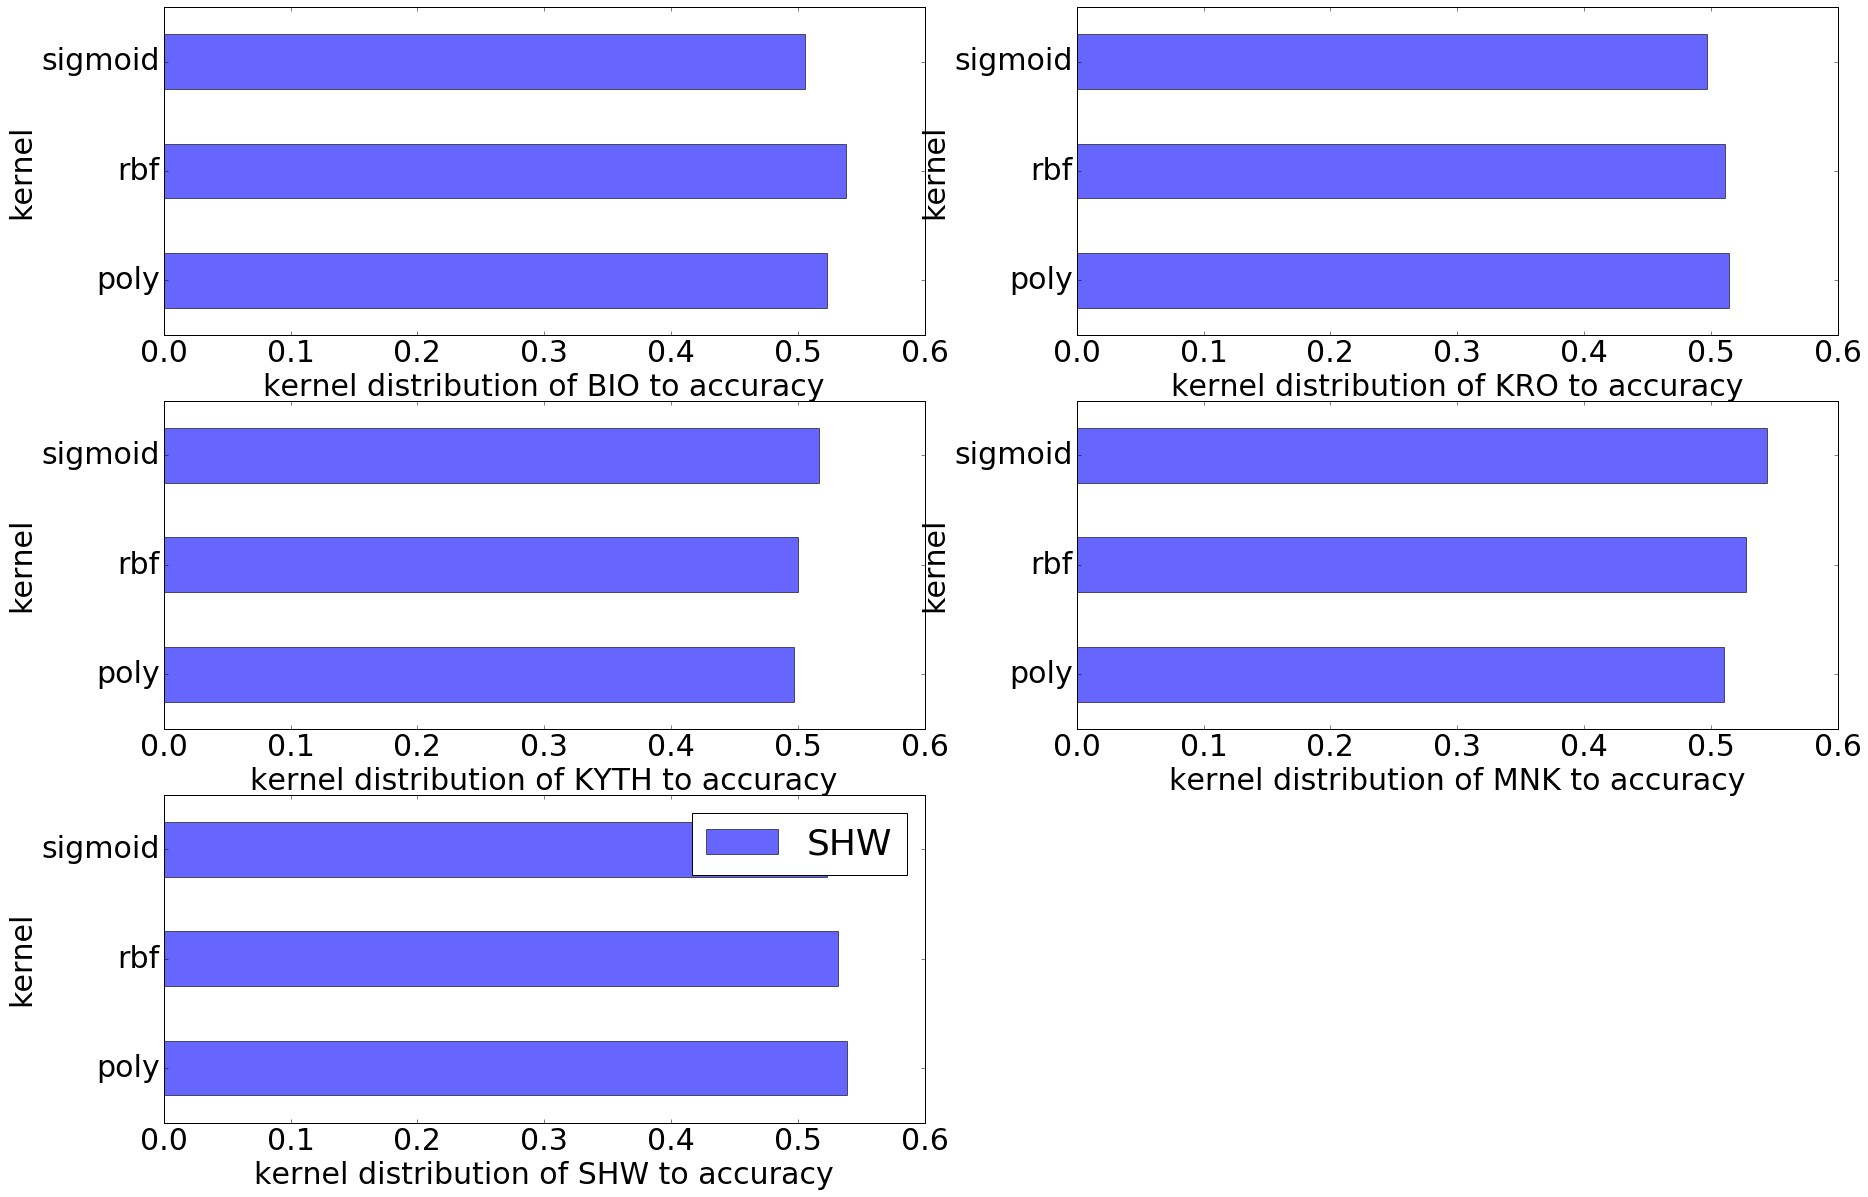

In [7]:
import numpy as np

%matplotlib inline

kernel=['rbf', 'poly', 'sigmoid']
models = [SVC(kernel=d) for d in kernel]
results = get_results(models)

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(results.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('kernel').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('kernel distribution of ' + name + ' to accuracy')
plt.legend(loc='best')


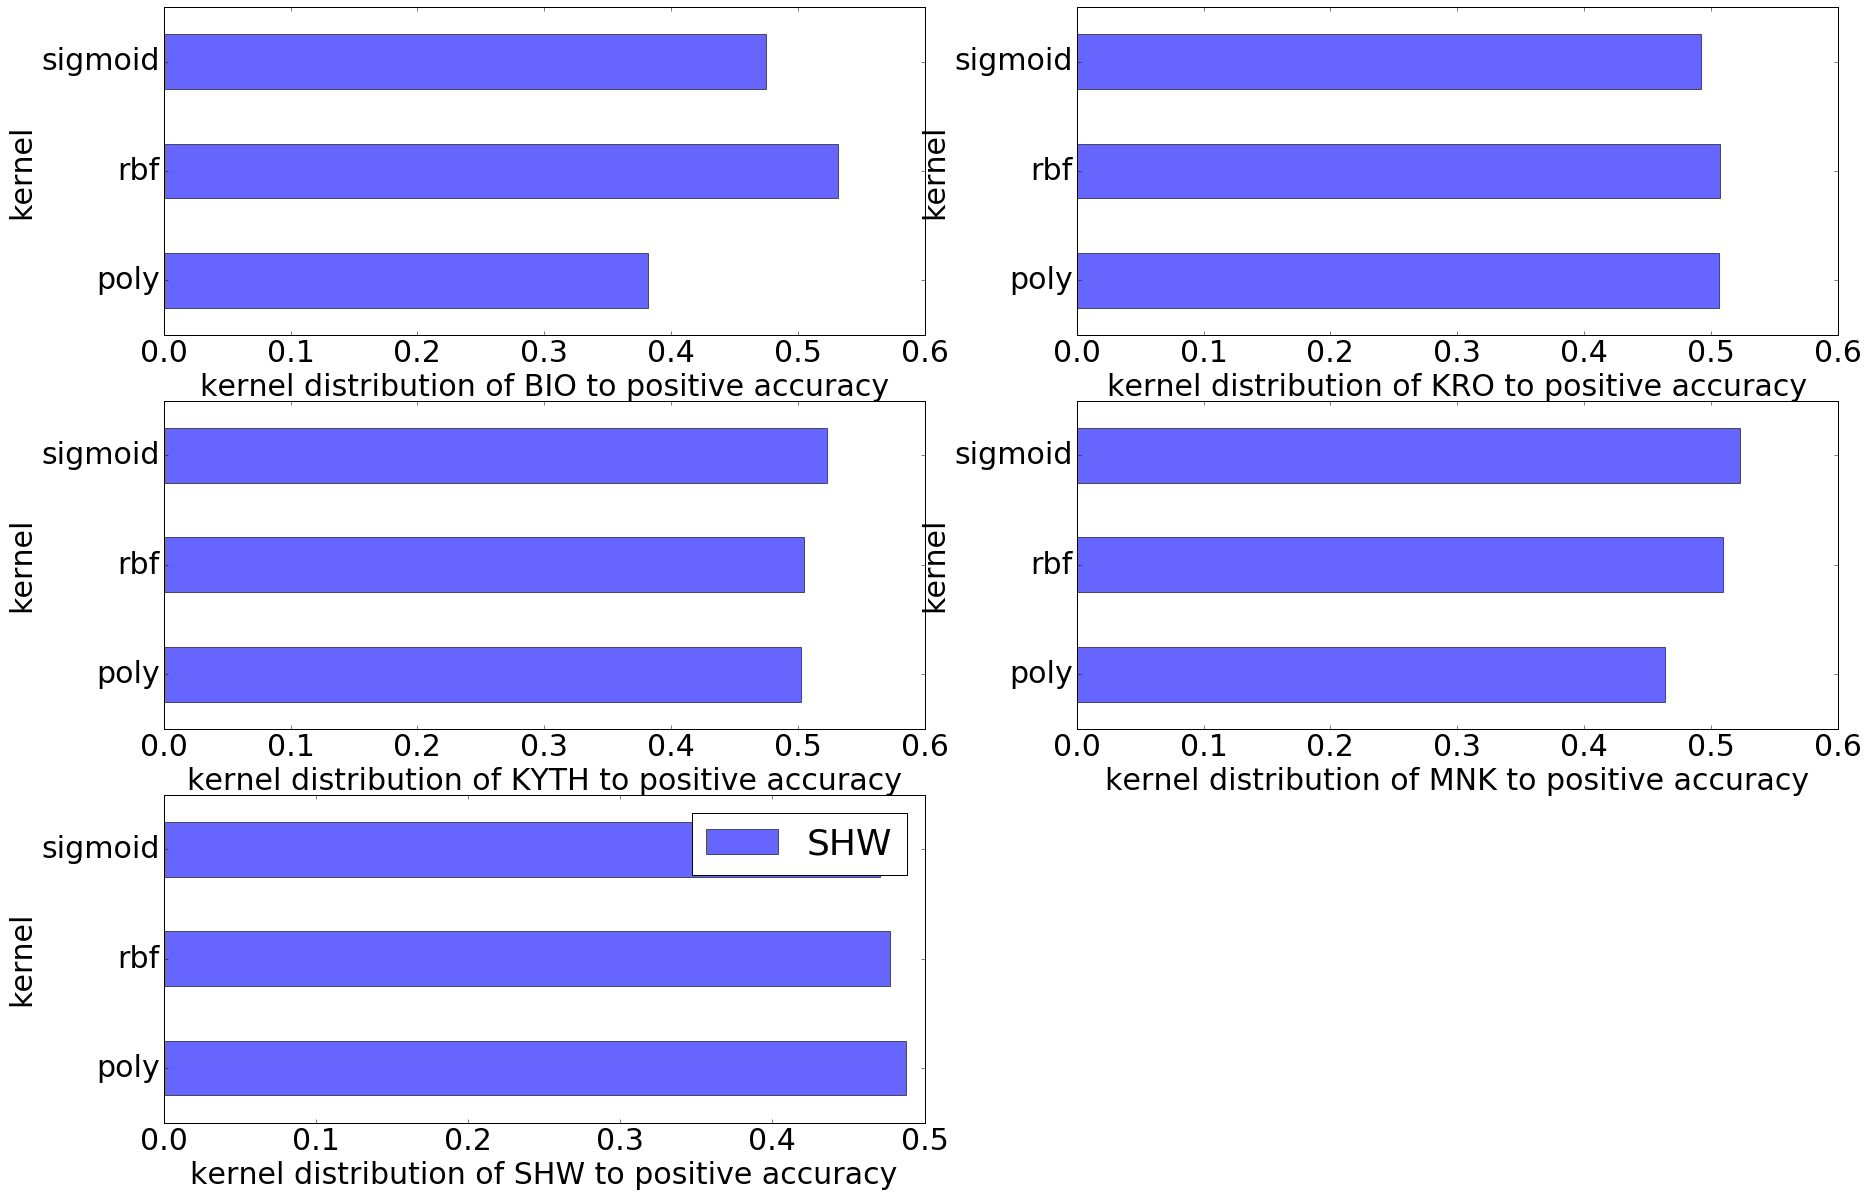

In [8]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(results.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('kernel').agg('mean')['positive acc'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('kernel distribution of ' + name + ' to positive accuracy')
plt.legend(loc='best')

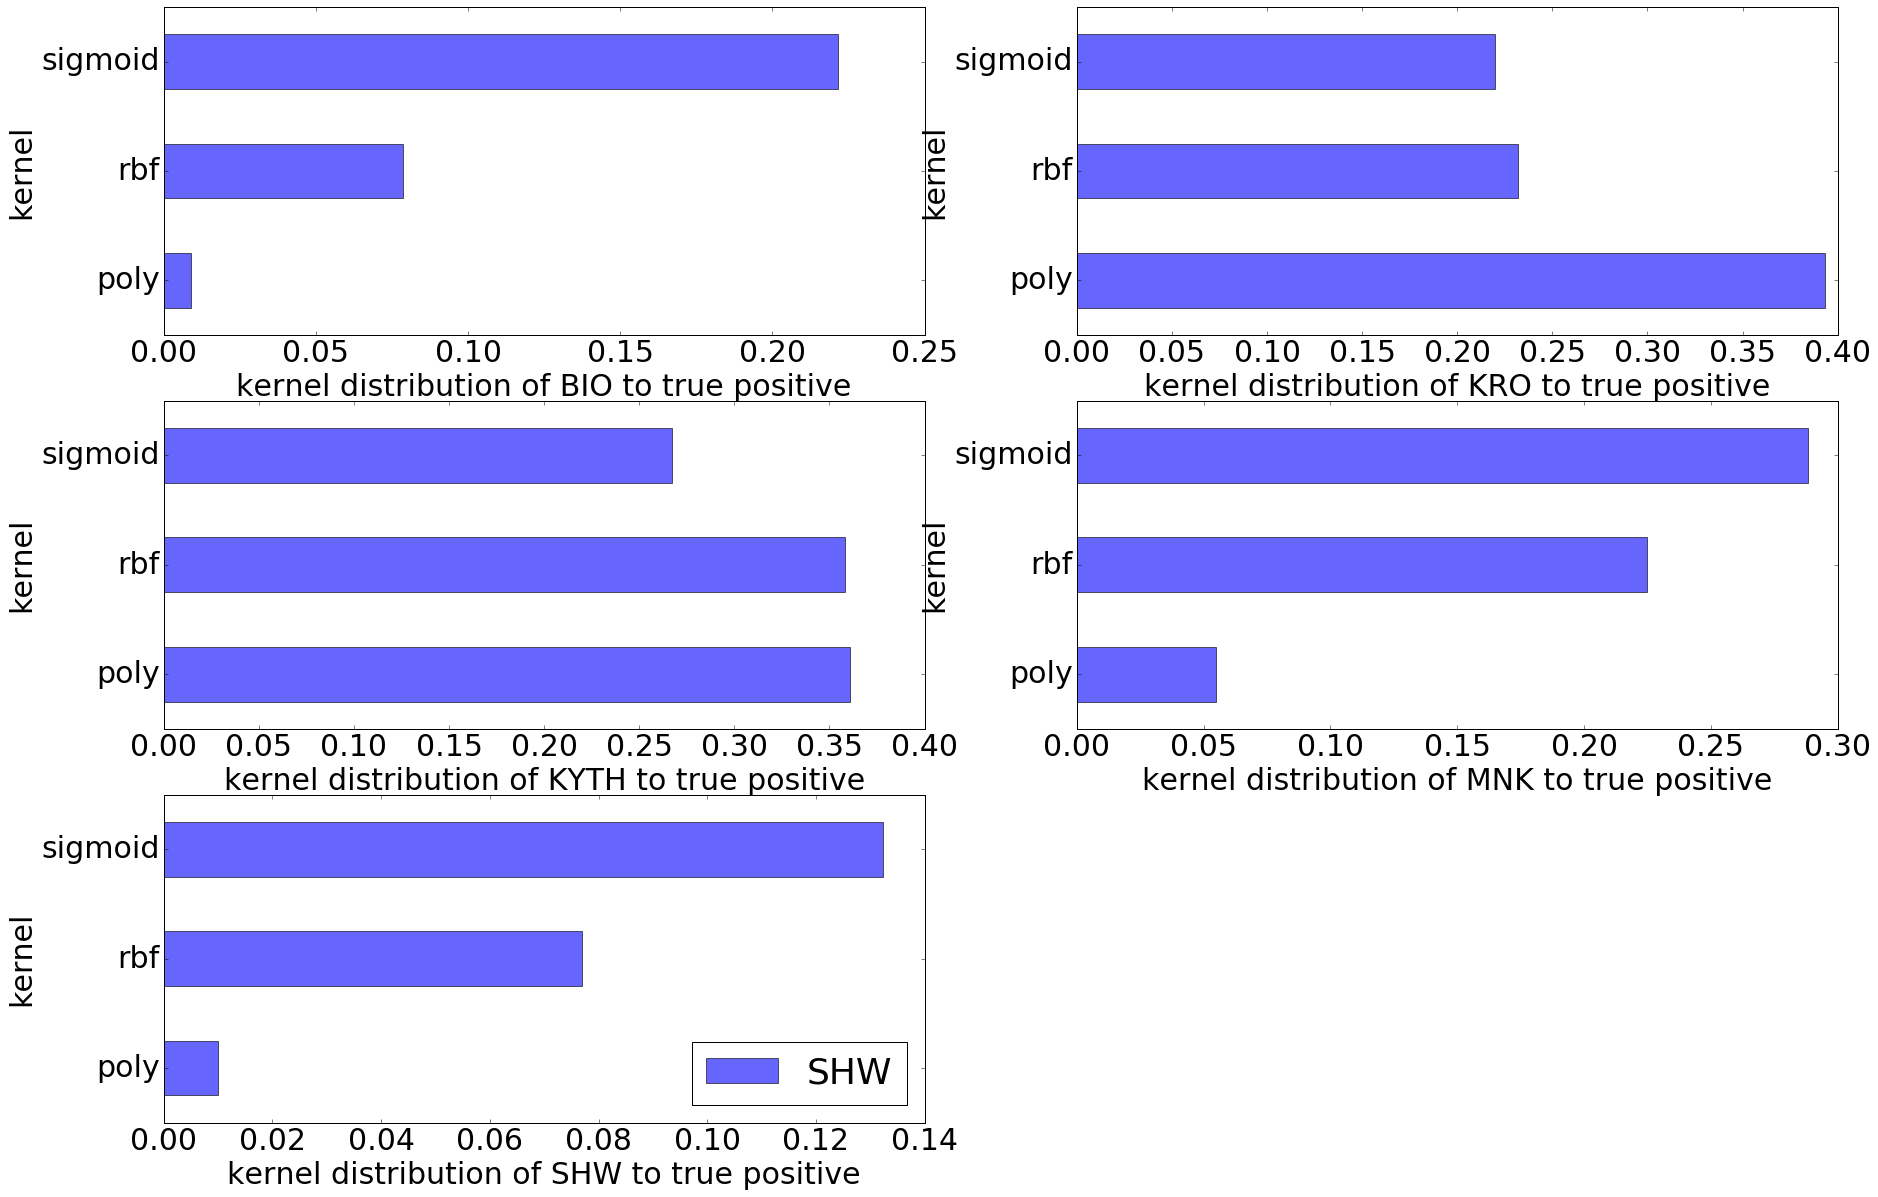

In [9]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(results.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('kernel').agg('mean')['true positive'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('kernel distribution of ' + name + ' to true positive')
plt.legend(loc='best')

In [10]:
import numpy as np
from sklearn.svm import SVC

# usually gamma is on auto which is 1/n_features. we will play with it a bit
n_features = stocks[0][0].shape[1]
gamma = [1/(n_features*n) for n in (0.1, 0.3, 0.5, 1.0, 1.1, 1.3, 1.5)] \
  + [n_features*n for n in (0.1, 0.3, 0.5, 1.0, 1.1, 1.3, 1.5)]
models = [SVC(gamma=d, kernel='sigmoid') for d in gamma]

In [11]:
results = get_results(models)

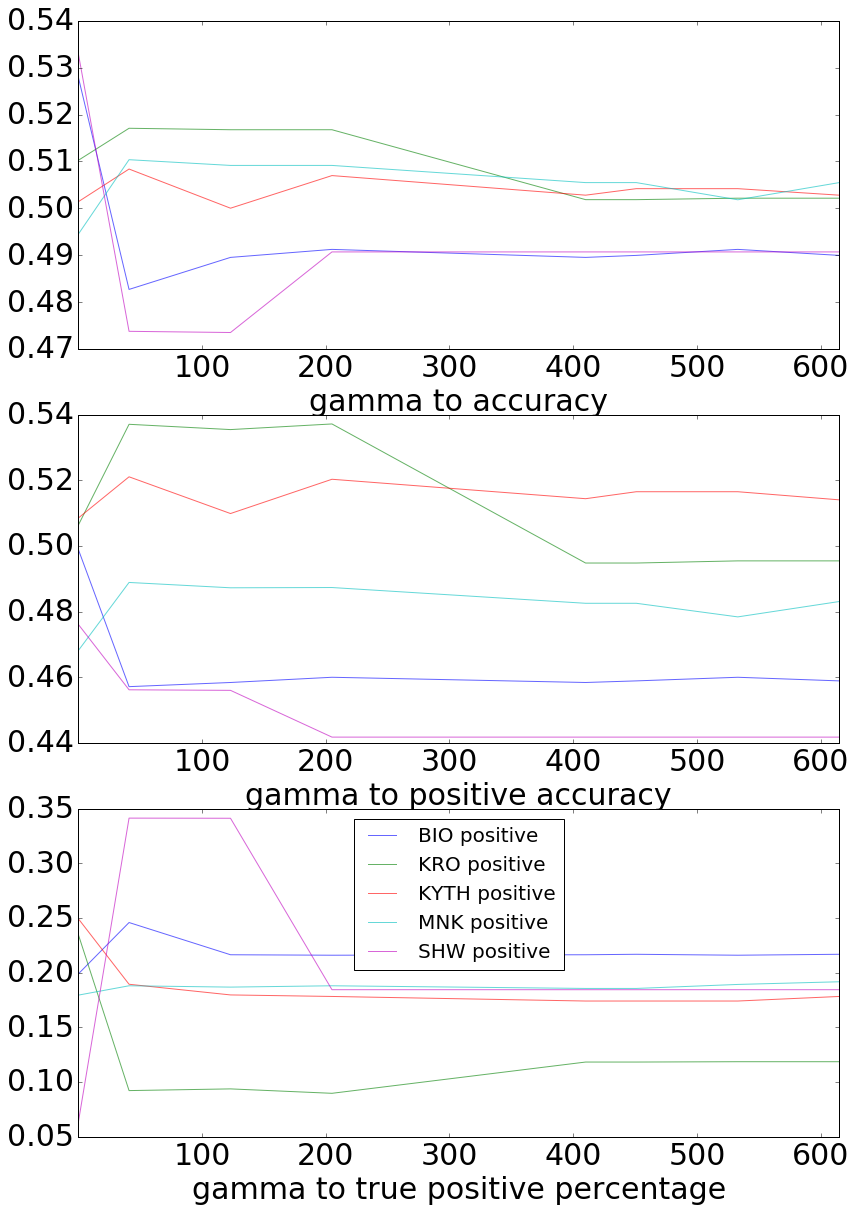

In [12]:
%matplotlib inline


plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('gamma').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('gamma to accuracy')

ax2 = plt.subplot2grid((3,2), (1,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 0).groupby('gamma').agg('mean')['positive acc'].plot(kind='line', label=name+' positive', alpha=alpha)
ax2.set_xlabel('gamma to positive accuracy')

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.groupby('gamma').agg('mean')['true positive'].plot(kind='line', label=name+' positive', alpha=alpha)
ax3.set_xlabel('gamma to true positive percentage')

plt.legend(loc='best', prop={'size':20})

In [13]:
aggr = results.groupby('gamma').agg('mean')
print(aggr.loc[aggr['accuracy'] == aggr['accuracy'].max()])
print(aggr.loc[aggr['positive acc'] == aggr['positive acc'].max()])
print(aggr.loc[aggr['true positive'] == aggr['true positive'].max()])

            C  max_iter  accuracy  positive acc  negative acc  true positive
gamma                                                                       
0.001626  1.0        -1  0.514527      0.495867      0.529773       0.229912
            C  max_iter  accuracy  positive acc  negative acc  true positive
gamma                                                                       
0.001626  1.0        -1  0.514527      0.495867      0.529773       0.229912
            C  max_iter  accuracy  positive acc  negative acc  true positive
gamma                                                                       
0.002217  1.0        -1  0.507635       0.48902      0.522079       0.247437


# Variance Reduction
We will try 3 approches. 

    1. using standard sklearn feature selection. 
    2. using relation strength classifier.

In [5]:
from sklearn.svm import SVC
gamma = 0.001626
model = SVC(kernel='sigmoid', gamma=gamma)
accs = run_model(model)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001626, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy: 0.5138200817302286


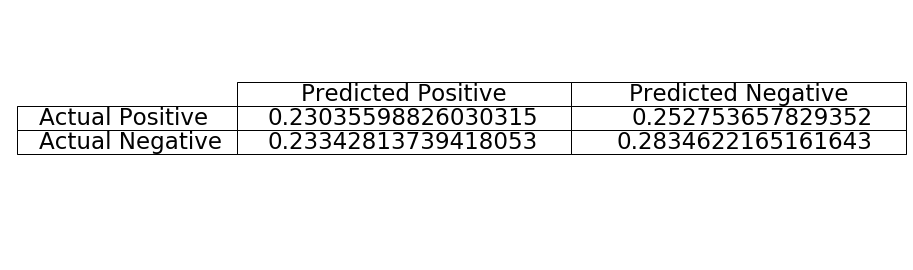

0.49668795355000345


In [15]:
concated_accs = ConfusionMatrix.concat(*list(accs.values()))
concated_accs.plot()
print(concated_accs.true_acc())

## Standard feature selection

We have plenty of samples so it seems wiser to use mutual_info score func, and trying to remove features by those who have small variance.

In [16]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

k_results = []
for i in range(51, 252, 15):
    filtered_stocks = [(pandas.DataFrame(SelectKBest(score_func=mutual_info_classif, k=i).fit_transform(data, classes)), pandas.Series(classes)) for data, classes in stocks]
    k_results.append((i, run_model(model, filtered_stocks)))


In [17]:
temp = k_results

In [18]:
k_results = []
for k, acc in temp:
    for tsn, cm in acc.items():
        k_results.append((k, tsn, cm.accuracy, cm.true_acc(), cm.false_acc(), cm.TruePos))

results = pandas.DataFrame(k_results, columns=('Kfeatures', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))

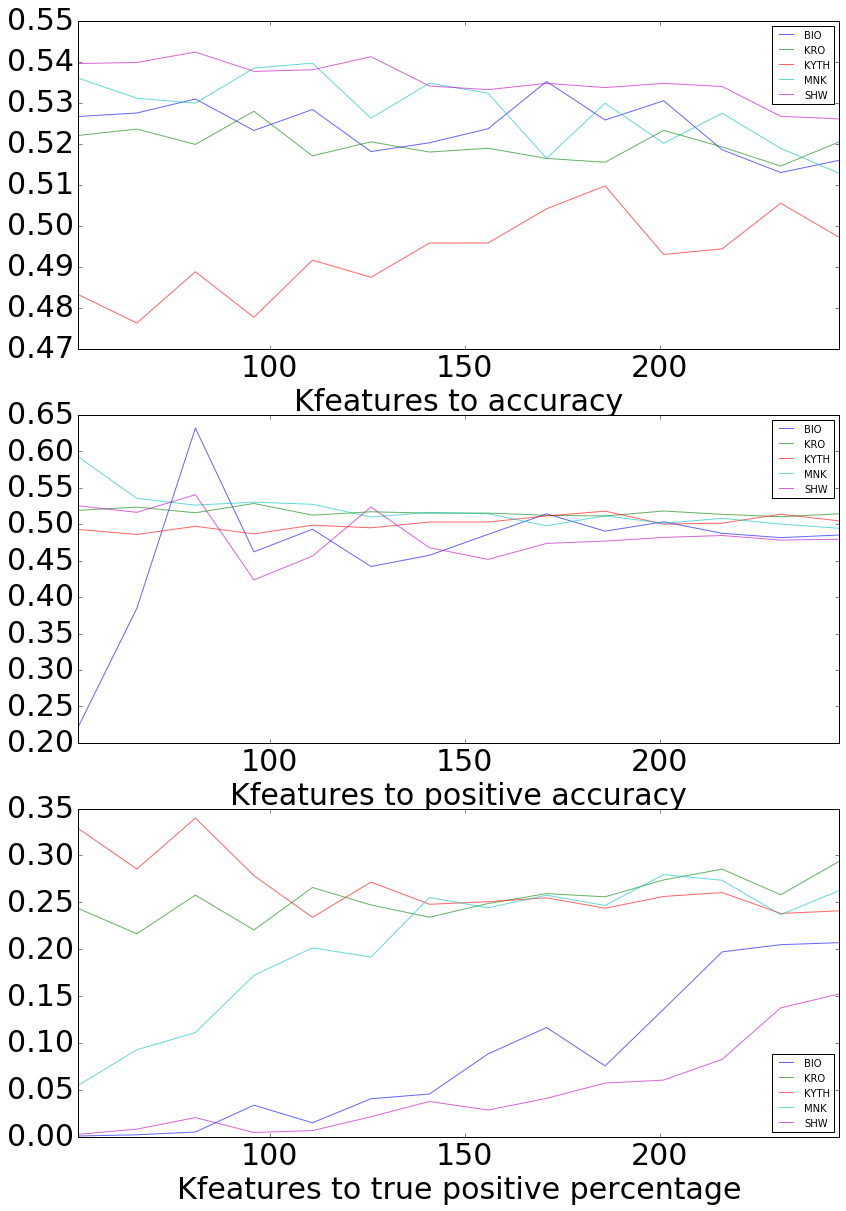

In [19]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('Kfeatures').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('Kfeatures to accuracy')
plt.legend(loc='best', prop={'size':10})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('Kfeatures').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('Kfeatures to positive accuracy')
plt.legend(loc='best', prop={'size':10})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 0).groupby('Kfeatures').agg('mean')['true positive'].plot(kind='line', label=name, alpha=alpha)
ax3.set_xlabel('Kfeatures to true positive percentage')
plt.legend(loc='best', prop={'size':10})

In [20]:
aggr = results.groupby('Kfeatures').agg('mean')
print(aggr.loc[aggr['accuracy'] == aggr['accuracy'].max()])
print(aggr.loc[aggr['positive acc'] == aggr['positive acc'].max()])
print(aggr.loc[aggr['true positive'] == aggr['true positive'].max()])

           accuracy  positive acc  negative acc  true positive
Kfeatures                                                     
111        0.522977      0.497408      0.524805       0.144569
           accuracy  positive acc  negative acc  true positive
Kfeatures                                                     
81         0.522394      0.542066      0.519828       0.146865
           accuracy  positive acc  negative acc  true positive
Kfeatures                                                     
246        0.514527      0.495388      0.528113       0.231324


In [21]:
from sklearn.feature_selection import VarianceThreshold

variance_threshold_results = []
for i in range(80, 101):
    try:
        thresh = float(i)/100
        variance_stocks = [(pandas.DataFrame(VarianceThreshold(threshold=thresh).fit_transform(data, classes)), 
                                 pandas.Series(classes)) for data, classes in stocks]
        variance_threshold_results.append((thresh, run_model(model, variance_stocks)))
    except Exception as e:
        print('Skipping threshold {} as it doesnt have enough variance: {}'.format(float(i)/100, str(e)))

In [22]:
variance_threshold_temp = variance_threshold_results

In [23]:
variance_threshold_results = []
for t, acc in variance_threshold_temp:
    for tsn, cm in acc.items():
        variance_threshold_results.append((t, tsn, cm.accuracy, cm.true_acc(), cm.false_acc(), cm.TruePos))

results = pandas.DataFrame(variance_threshold_results, columns=('VThreshold', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))

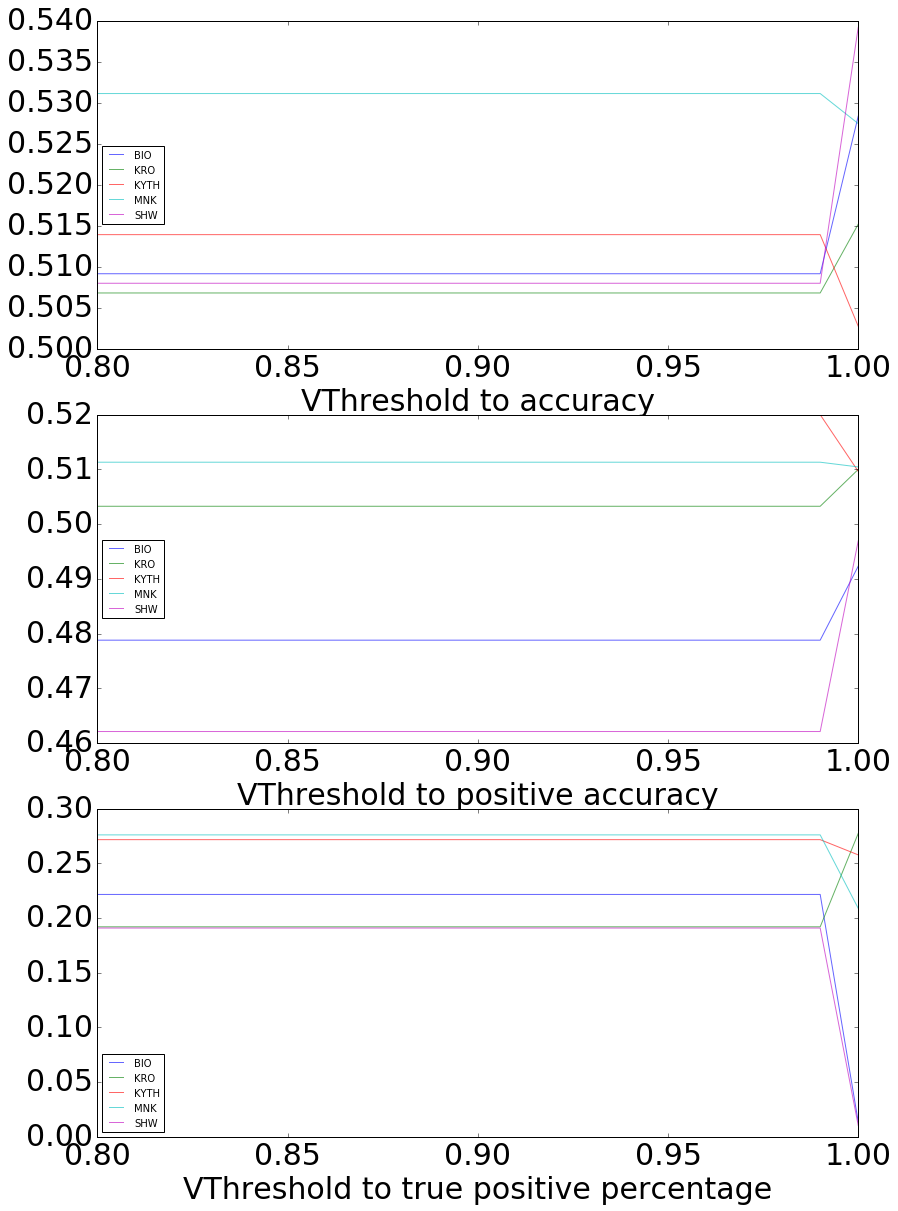

In [24]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('VThreshold').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('VThreshold to accuracy')
plt.legend(loc='best', prop={'size':10})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('VThreshold').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('VThreshold to positive accuracy')
plt.legend(loc='best', prop={'size':10})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 0).groupby('VThreshold').agg('mean')['true positive'].plot(kind='line', label=name, alpha=alpha)
ax3.set_xlabel('VThreshold to true positive percentage')
plt.legend(loc='best', prop={'size':10})

## Bagging

In [25]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVR
import sklearn
base_estimator = model
n_estimators = [10]
max_samples = [0.5, 0.8, 1]
max_features = [0.5, 0.8, 1]
n_jobs = 1
import Classifiers.classifiers

# We will use SVR to get predict_proba working
model = SVC(kernel='sigmoid', gamma=gamma, probability=True)
bagging_models = [BaggingClassifier(max_samples=s, max_features=f, n_estimators=n, base_estimator=model) 
          for n, s, f in product(n_estimators, max_samples, max_features)]


In [26]:
print(bagging_models[0])
bagging_accs = list(map(run_model, bagging_models))

BaggingClassifier(base_estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001626, kernel='sigmoid',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=0.5, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)


NotFittedError: predict_proba is not available when fitted with probability=False

In [ ]:
def get_bagging_results(models=bagging_models, accuracies=bagging_accs):
    if accuracies is None:
        accuracies = list(map(run_model_t, models))
    # data should be list of lists and each row should be:
    # criterion, max_depth, min_samples, stock, accuracy
    data = []
    for tmodel, taccs in zip(models, accuracies):
        for tsn, cm in taccs.items():
            data.append((tmodel.max_samples, tmodel.max_features, tmodel.n_estimators, tsn, cm.accuracy, cm.true_acc(), cm.false_acc(), cm.TruePos))
    results = DataFrame(data, columns=('max_samples', 'max_features', 'n_estimators', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))
    return results

## Strength Classifier using relationship strengths

In [6]:
from Utilities.clustering import StrengthCalc

sc = StrengthCalc()

In [7]:
from Classifiers.classifiers import ConnectionStrengthClassifier

# dictionary of market name to strength
stock_strengths = [sc.get_strength_stock(sn, 5, 325, 2, 0.1) for sn in stock_names]

clf = ConnectionStrengthClassifier()

In [8]:
from Utilities import clean_market_name

cols = []
for d, c in stocks:
    cols.extend(d.columns)
all_cols = set(cols)

strengths = []
connections_cols = []
for i, sn in enumerate(stock_names):
    cur_cols = []
    cur_strengths = []
    for m in ld.get_market_names():
        cur_cols.append(list(filter(lambda c: clean_market_name(m) in c, all_cols)))
        cur_strengths.append(stock_strengths[i][m])
    connections_cols.append(cur_cols)
    strengths.append(cur_strengths)

In [9]:
def run_strength_model(model, stocks=stocks, strength=strengths, cols=connections_cols):
    scores = {sn: [] for sn in stock_names}
    for sn, data, st, cs in zip(stock_names, stocks, strength, cols):
        scores[sn] = (ConfusionMatrix(data, model,st,cs)) 
    return scores

In [10]:
import Classifiers.classifiers

model = SVC(kernel='sigmoid', gamma=gamma, probability=True)
st_accuracies = run_strength_model(ConnectionStrengthClassifier(base_estimator=model, njobs=6))

ConnectionStrengthClassifier(base_estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001626, kernel='sigmoid',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
               base_strength=0.5, combined_weight=0.5, njobs=6,
               threshold=0.1)
Accuracy: 0.5093510983107882


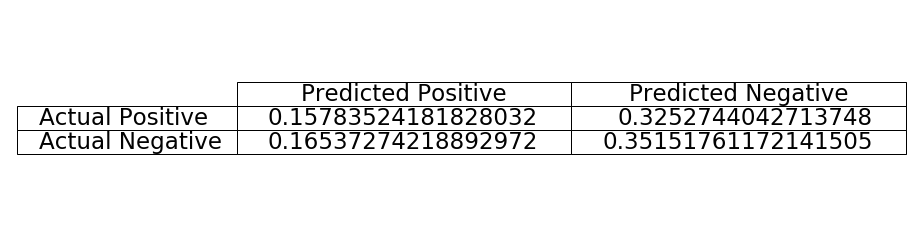

In [12]:
ConfusionMatrix.concat(*list(st_accuracies.values())).plot()

## Improving svm using connection strength classifier
by manipulating threshold, base_strength and combined_weight

#### threshold

In [44]:
import importlib
Classifiers = importlib.reload(Classifiers)

from pandas import DataFrame
def get_results_class_weigth_dict(results):
    # data should be list of lists and each row should be:
    # criterion, max_depth, min_samples, stock, accuracy
    data = []
    for x_values in (results.keys()):
        # print(x_values)
        for st in results[x_values].keys():
            c = results[x_values][st]
            data.append((c.model.threshold,c.model.base_strength,c.model.combined_weight,st,c.accuracy,c.true_acc(), c.false_acc(), c.TruePos))
#             for tsn, cm in taccs.items():
#                 data.append((tmodel.threshold,tmodel.base_strength,tmodel.combined_weight, tmodel.class_weight[True], tsn, cm.accuracy, cm.true_acc(), cm.false_acc(), cm.TruePos))
    df_results = DataFrame(data, columns=('threshold','base_strength','combined_weight', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))
    return df_results

In [11]:
thresholds = [0.001,0.08,0.15]
bs = [0.1,0.5,0.9]
cw = [0.1,0.5,0.9]
ConnectionStrengthClassifier = Classifiers.classifiers.ConnectionStrengthClassifier

all_models = [ConnectionStrengthClassifier(threshold=t, base_strength=b, combined_weight=c, njobs=6,
              base_estimator=model) for t, b, c in product(thresholds, bs, cw)]
all_results = dict.fromkeys(product(thresholds, bs, cw))
# for k, m in zip(product(thresholds, bs, cw), all_models):
#     all_results[k] = run_strength_model(m)

In [13]:
sc_accs = [run_strength_model(m) for m in all_models]

In [54]:
from pandas import DataFrame
data = []
for m, accs in zip(all_models, sc_accs):
    for st, c in accs.items():
        true_w = None
        if c.model.base_estimator.class_weight:
            true_w = c.model.base_estimator.class_weight[True]
        data.append((c.model.threshold, c.model.base_strength, c.model.combined_weight, true_w, st, c.accuracy,c.true_acc(), c.false_acc(), c.TruePos))
results = DataFrame(data, columns=('threshold','base_strength','combined_weight', 'true weight', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))        

/home/eytan/work/Stockifier/Utilities/confusion_matrix.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return self.TruePos / (self.TruePos + self.FalsePos)


In [ ]:
from pandas import DataFrame
data = []
for i, dcm in enumerate(all_results):
    for st in dcm.keys():
        c = dcm[st]
        true_w = None
        if c.model.base_estimator.class_weight:
            true_w = c.model.base_estimator.class_weight[True]
        data.append((c.model.threshold, c.model.base_strength, c.model.combined_weight, true_w, st, c.accuracy,c.true_acc(), c.false_acc(), c.TruePos))
results = DataFrame(data, columns=('threshold','base_strength','combined_weight', 'true weight', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))

In [55]:
gr_res = results
bs_res = results
gr_cw_results = results

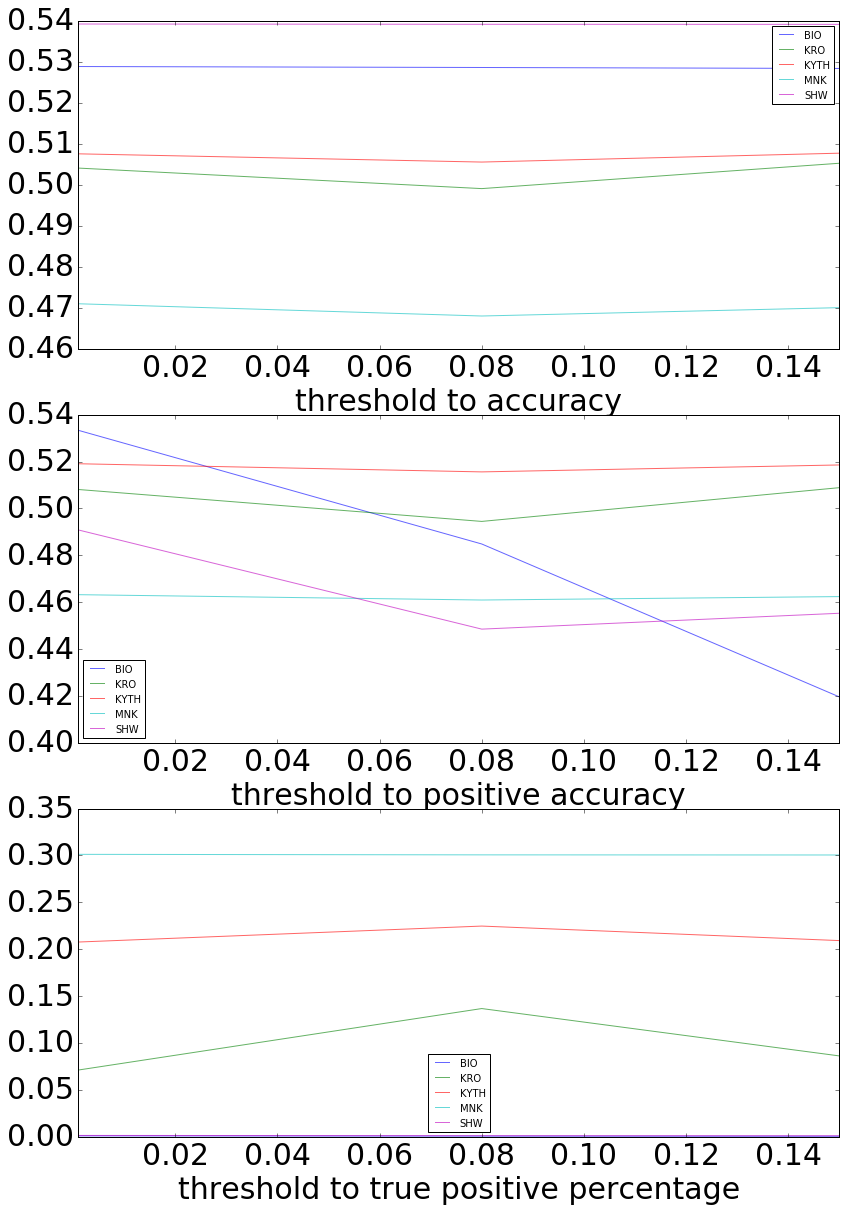

In [56]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in gr_res.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('threshold').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('threshold to accuracy')
plt.legend(loc='best', prop={'size':10})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in gr_res.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('threshold').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('threshold to positive accuracy')
plt.legend(loc='best', prop={'size':10})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in gr_res.groupby('stock'):
    group.replace(np.nan, 0).groupby('threshold').agg('mean')['true positive'].plot(kind='line', label=name, alpha=alpha)
ax3.set_xlabel('threshold to true positive percentage')
plt.legend(loc='best', prop={'size':10})

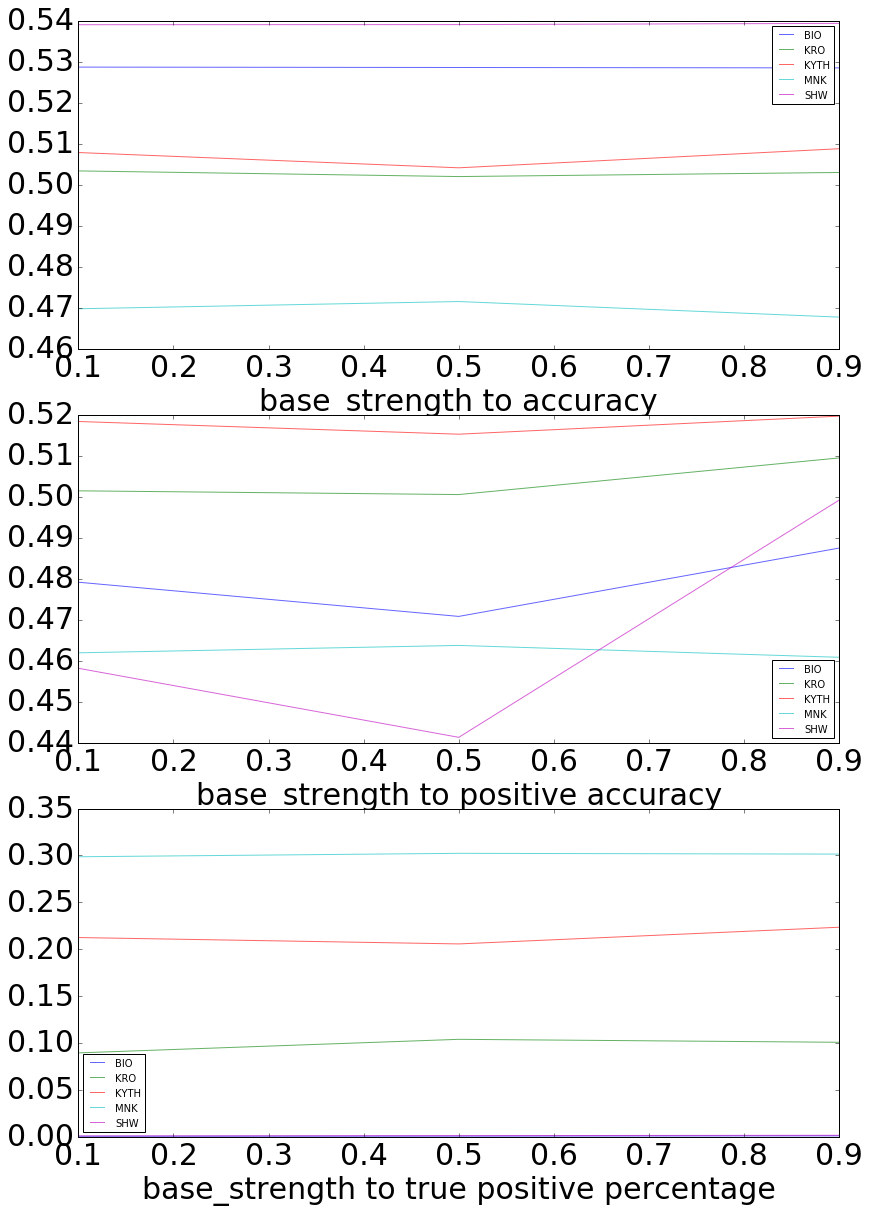

In [57]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in bs_res.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('base_strength').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('base_strength to accuracy')
plt.legend(loc='best', prop={'size':10})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in bs_res.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('base_strength').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('base_strength to positive accuracy')
plt.legend(loc='best', prop={'size':10})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in bs_res.groupby('stock'):
    group.replace(np.nan, 0).groupby('base_strength').agg('mean')['true positive'].plot(kind='line', label=name, alpha=alpha)
ax3.set_xlabel('base_strength to true positive percentage')
plt.legend(loc='best', prop={'size':10})

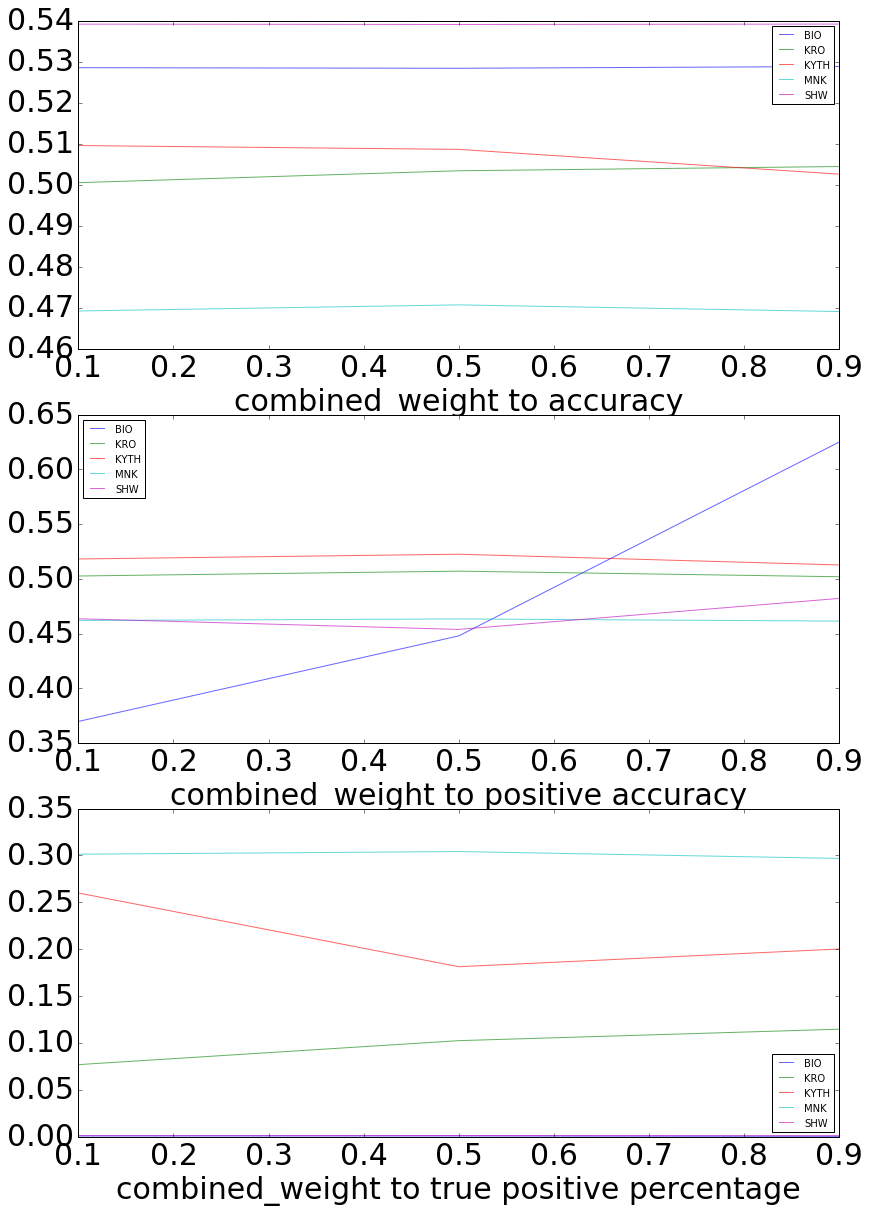

In [58]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in gr_cw_results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('combined_weight').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('combined_weight to accuracy')
plt.legend(loc='best', prop={'size':10})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in gr_cw_results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('combined_weight').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('combined_weight to positive accuracy')
plt.legend(loc='best', prop={'size':10})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in gr_cw_results.groupby('stock'):
    group.replace(np.nan, 0).groupby('combined_weight').agg('mean')['true positive'].plot(kind='line', label=name, alpha=alpha)
ax3.set_xlabel('combined_weight to true positive percentage')
plt.legend(loc='best', prop={'size':10})

In [59]:
aggr = results.groupby(['threshold', 'base_strength', 'combined_weight']).agg('mean')
aggr.loc[aggr['accuracy'] == aggr['accuracy'].max()]

,,,accuracy,positive acc,negative acc,true positive
threshold,base_strength,combined_weight,,,,
0.001,0.5,0.9,0.513623,0.480973,0.516416,0.111606


In [60]:
aggr.loc[aggr['positive acc'] == aggr['positive acc'].max()]

,,,accuracy,positive acc,negative acc,true positive
threshold,base_strength,combined_weight,,,,
0.15,0.1,0.9,0.508232,0.579244,0.509662,0.106082


In [61]:
aggr.loc[aggr['true positive'] == aggr['true positive'].max()]

,,,accuracy,positive acc,negative acc,true positive
threshold,base_strength,combined_weight,,,,
0.001,0.9,0.1,0.508521,0.497071,0.510356,0.154232


In [62]:
import Classifiers
logging.getLogger().setLevel(logging.CRITICAL)
model = SVC(gamma=gamma, kernel='sigmoid', probability=True)
final_model = Classifiers.classifiers.ConnectionStrengthClassifier(threshold=0.15, base_strength=0.1, combined_weight=0.9, 
              base_estimator=model)
final_cm = run_strength_model(final_model)

ConnectionStrengthClassifier(base_estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001626, kernel='sigmoid',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
               base_strength=0.1, combined_weight=0.9, njobs=None,
               threshold=0.15)
Accuracy: 0.5077925445378586


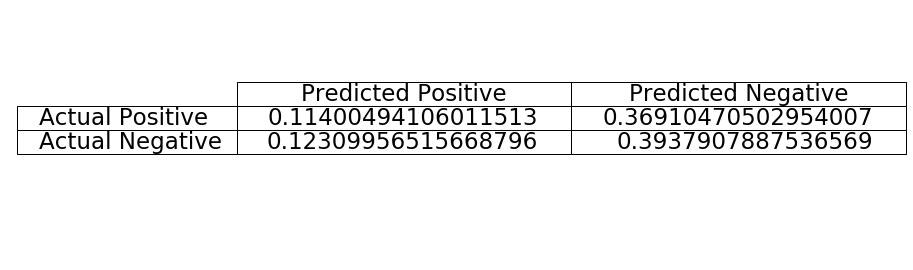

In [63]:
ConfusionMatrix.concat(*list(final_cm.values())).plot()

In [ ]:
## overfitting
from sklearn.metrics import accuracy_score
for (d,c),s,cols in zip(stocks, strengths, connections_cols):
    final_model.fit(d,c, cols, s)
    print(accuracy_score(c, final_model.predict(d)))

In [34]:
# overfitting
model = SVC(gamma=gamma, kernel='sigmoid')
from sklearn.metrics import accuracy_score
for (d,c),s,cols in zip(stocks, strengths, connections_cols):
    model.fit(d,c)
    print(accuracy_score(c, model.predict(d)))

0.496308553971
0.537240537241
0.503627827571
0.550139275766
0.499378881988


In [65]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

filtered_stocks = [(pandas.DataFrame(SelectKBest(score_func=mutual_info_classif, k=81).fit_transform(data, classes)), pandas.Series(classes)) for data, classes in stocks]
cm = run_model(model, filtered_stocks)
for d,c in filtered_stocks:
    model.fit(d,c)
    print(accuracy_score(c, model.predict(d)))

0.535514256619
0.547008547009
0.527102005975
0.526462395543
0.524223602484
